# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Hanif Herofa
- **Email:** mc200d5y2221@student.devacademy.id
- **ID Dicoding:** MC200D5Y2221

## Import Semua Packages/Library yang Digunakan

In [3]:
import sys
print(sys.executable)
# tensorflow                   2.19.0
# tensorflow-estimator         2.15.0
# tensorflow-hub               0.12.0
# tensorflow-intel             2.15.0
# tensorflow-io-gcs-filesystem 0.31.0
# tensorflowjs                 3.18.0

c:\Users\user\anaconda3\envs\image-classification-env\python.exe


In [4]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import datetime
import shutil
import random
import tensorflowjs as tfjs

## Data Preparation

### Data Loading

In [5]:
# Konstanta dan konfigurasi
TRAIN_DIR = 'train'
TEST_DIR = 'test'
TRAINING_CSV = 'Training_set.csv'
TESTING_CSV = 'Testing_set.csv'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.2  # 20% dari data training untuk validasi

# Buat direktori untuk validasi
VALIDATION_DIR = 'validation'
os.makedirs(VALIDATION_DIR, exist_ok=True)

# Membaca file CSV
print("Membaca file CSV...")
train_df = pd.read_csv(TRAINING_CSV)
test_df = pd.read_csv(TESTING_CSV)

# Melihat struktur data
print("Data Training:")
print(train_df.head())
print(f"Jumlah data training: {len(train_df)}")

print("\nData Testing:")
print(test_df.head())
print(f"Jumlah data testing: {len(test_df)}")

# Menghitung jumlah kelas unik
num_classes = train_df['label'].nunique()
print(f"\nJumlah kelas kupu-kupu: {num_classes}")

# Melihat distribusi kelas
class_distribution = train_df['label'].value_counts()
print("\nDistribusi kelas:")
print(class_distribution)

Membaca file CSV...
Data Training:
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
Jumlah data training: 6499

Data Testing:
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg
Jumlah data testing: 2786

Jumlah kelas kupu-kupu: 75

Distribusi kelas:
label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64


### Data Preprocessing

#### Split Dataset

Jumlah data train setelah split: 5199
Jumlah data validasi: 1300
Menyiapkan struktur direktori...
Menganalisis resolusi gambar...


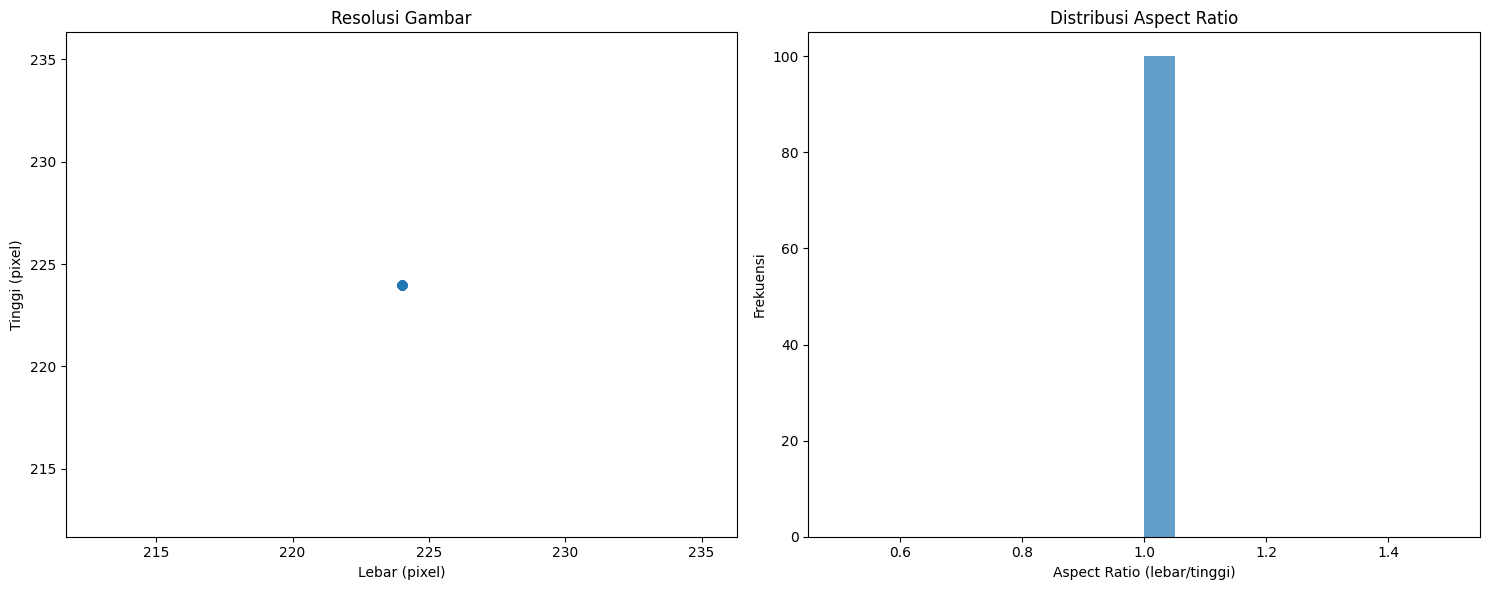

Resolusi gambar: Min 224x224, Max 224x224
Resolusi rata-rata: 224.0x224.0
Resolusi median: 224.0x224.0
Menyiapkan data generators...
Membuat generators dari direktori...
Found 1300 images belonging to 75 classes.
Mapping kelas ke indeks:
{'ADONIS': 0, 'AFRICAN GIANT SWALLOWTAIL': 1, 'AMERICAN SNOOT': 2, 'AN 88': 3, 'APPOLLO': 4, 'ATALA': 5, 'BANDED ORANGE HELICONIAN': 6, 'BANDED PEACOCK': 7, 'BECKERS WHITE': 8, 'BLACK HAIRSTREAK': 9, 'BLUE MORPHO': 10, 'BLUE SPOTTED CROW': 11, 'BROWN SIPROETA': 12, 'CABBAGE WHITE': 13, 'CAIRNS BIRDWING': 14, 'CHECQUERED SKIPPER': 15, 'CHESTNUT': 16, 'CLEOPATRA': 17, 'CLODIUS PARNASSIAN': 18, 'CLOUDED SULPHUR': 19, 'COMMON BANDED AWL': 20, 'COMMON WOOD-NYMPH': 21, 'COPPER TAIL': 22, 'CRECENT': 23, 'CRIMSON PATCH': 24, 'DANAID EGGFLY': 25, 'EASTERN COMA': 26, 'EASTERN DAPPLE WHITE': 27, 'EASTERN PINE ELFIN': 28, 'ELBOWED PIERROT': 29, 'GOLD BANDED': 30, 'GREAT EGGFLY': 31, 'GREAT JAY': 32, 'GREEN CELLED CATTLEHEART': 33, 'GREY HAIRSTREAK': 34, 'INDRA SWA

In [6]:
# Membagi data training menjadi train dan validation
train_subset, val_subset = train_test_split(
    train_df, 
    test_size=VALIDATION_SPLIT, 
    random_state=42,
    stratify=train_df['label']  # Stratified split untuk menjaga distribusi kelas
)

print(f"Jumlah data train setelah split: {len(train_subset)}")
print(f"Jumlah data validasi: {len(val_subset)}")

# Fungsi untuk mempersiapkan folder menggunakan symlink
def prepare_directory_structure():
    # Hapus directory validasi jika sudah ada untuk menghindari file ganda
    if os.path.exists(VALIDATION_DIR):
        shutil.rmtree(VALIDATION_DIR)
    os.makedirs(VALIDATION_DIR, exist_ok=True)
    
    # Temukan semua kelas unik dari data training
    classes = train_df['label'].unique()
    
    # Buat folder untuk setiap kelas dalam validation directory
    for class_name in classes:
        os.makedirs(os.path.join(VALIDATION_DIR, class_name), exist_ok=True)
    
    # Pindahkan file validasi ke folder validation
    for _, row in val_subset.iterrows():
        img_filename = row['filename']
        label = row['label']
        
        # Buat symbolic link dari file train ke validation
        src_path = os.path.join(TRAIN_DIR, img_filename)
        dst_path = os.path.join(VALIDATION_DIR, label, os.path.basename(img_filename))
        
        try:
            # Jika OS mendukung symlink (Linux/Mac)
            os.symlink(os.path.abspath(src_path), dst_path)
        except:
            # Jika symlink tidak didukung (Windows), salin file
            shutil.copy2(src_path, dst_path)

# Panggil fungsi untuk menyiapkan struktur direktori
print("Menyiapkan struktur direktori...")
prepare_directory_structure()

# Analisis Resolusi Gambar
print("Menganalisis resolusi gambar...")

def analyze_image_resolutions(directory, sample_size=100):
    resolutions = []
    aspect_ratios = []
    files_analyzed = 0
    
    # Jika input adalah direktori dengan subdirektori kelas
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path)
                    width, height = img.size
                    resolutions.append((width, height))
                    aspect_ratios.append(width / height)
                    files_analyzed += 1
                    
                    if files_analyzed >= sample_size:
                        return resolutions, aspect_ratios
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return resolutions, aspect_ratios

# Analisis sampel gambar dari training set
resolutions, aspect_ratios = analyze_image_resolutions(TRAIN_DIR)

# Plot histogram resolusi dan aspect ratio
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
widths = [r[0] for r in resolutions]
heights = [r[1] for r in resolutions]
plt.scatter(widths, heights, alpha=0.5)
plt.title('Resolusi Gambar')
plt.xlabel('Lebar (pixel)')
plt.ylabel('Tinggi (pixel)')

plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=20, alpha=0.7)
plt.title('Distribusi Aspect Ratio')
plt.xlabel('Aspect Ratio (lebar/tinggi)')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

# Tampilkan statistik resolusi
print(f"Resolusi gambar: Min {min(widths)}x{min(heights)}, Max {max(widths)}x{max(heights)}")
print(f"Resolusi rata-rata: {np.mean(widths):.1f}x{np.mean(heights):.1f}")
print(f"Resolusi median: {np.median(widths)}x{np.median(heights)}")

# Augmentasi dan Preprocessing Data
print("Menyiapkan data generators...")

# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya scaling untuk validation dan test
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari direktori
print("Membuat generators dari direktori...")

# Untuk train, gunakan dataframe subset untuk memfilter hanya gambar training
# Kita perlu membuat generator khusus karena struktur data tidak standar
def generate_from_dataframe(dataframe, directory, batch_size=32):
    num_samples = len(dataframe)
    while True:
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle
        for start_idx in range(0, num_samples, batch_size):
            batch_df = dataframe.iloc[start_idx:min(start_idx + batch_size, num_samples)]
            batch_x = []
            batch_y = []
            
            for _, row in batch_df.iterrows():
                img_path = os.path.join(directory, row['filename'])
                try:
                    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                    img_array = img_to_array(img)
                    img_array = img_array / 255.0  # Rescale
                    batch_x.append(img_array)
                    
                    # One-hot encode labels
                    label_idx = class_indices[row['label']]
                    y = np.zeros(num_classes)
                    y[label_idx] = 1
                    batch_y.append(y)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
            
            if batch_x:
                yield np.array(batch_x), np.array(batch_y)

# Menggunakan flow_from_directory untuk validation set
validation_generator = valid_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mendapatkan pemetaan class_indices
class_indices = validation_generator.class_indices
print("Mapping kelas ke indeks:")
print(class_indices)

# Inverse mapping untuk prediksi nantinya
idx_to_class = {v: k for k, v in class_indices.items()}

# Gunakan generator kustom untuk train set
train_generator = generate_from_dataframe(
    train_subset, 
    TRAIN_DIR, 
    BATCH_SIZE
)

## Modelling

In [ ]:
# Membuat Model CNN
print("Membuat model CNN...")

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Block 4
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Flatten dan Fully Connected layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model
model.summary()

# Callbacks
print("Menyiapkan callbacks...")

# Path untuk menyimpan model terbaik
checkpoint_path = "best_model.h5"

# Early stopping untuk menghentikan training jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint untuk menyimpan model terbaik
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate jika plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Train Model
print("Melatih model...")

# Hitung steps_per_epoch dan validation_steps
steps_per_epoch = len(train_subset) // BATCH_SIZE
validation_steps = len(val_subset) // BATCH_SIZE

# Pastikan nilai minimum 1
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

print(f"Training dengan {steps_per_epoch} steps per epoch")
print(f"Validasi dengan {validation_steps} validation steps")

# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback],
    verbose=1
)

Membuat model CNN...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                        

## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi Model
print("Evaluasi model...")

# Load model terbaik
best_model = load_model(checkpoint_path)

# Evaluasi pada validation set
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation loss: {val_loss:.4f}')

# Plot Training History
print("Membuat plot training history...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.axhline(y=0.85, color='r', linestyle='--', label='Target Accuracy (85%)')
plt.axhline(y=0.95, color='g', linestyle='--', label='Target Accuracy (95%)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Prediksi pada Test Set
print("Melakukan prediksi pada test set...")

# Fungsi untuk memuat dan preprocess gambar
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
    return img_array

# Prediksi untuk test set
predictions = []
filenames = []

for _, row in test_df.iterrows():
    img_path = os.path.join(TEST_DIR, row['filename'])
    try:
        img_array = load_and_preprocess_image(img_path)
        prediction = best_model.predict(img_array)
        predicted_class_idx = np.argmax(prediction[0])
        predicted_class = idx_to_class[predicted_class_idx]
        confidence = prediction[0][predicted_class_idx]
        
        predictions.append({
            'filename': row['filename'],
            'predicted_class': predicted_class,
            'confidence': confidence
        })
        filenames.append(row['filename'])
    except Exception as e:
        print(f"Error predicting {img_path}: {e}")

# Visualisasi Hasil Prediksi
print("Visualisasi hasil prediksi...")

# Pilih beberapa sampel acak untuk visualisasi
num_samples = min(10, len(predictions))
sample_indices = random.sample(range(len(predictions)), num_samples)

plt.figure(figsize=(15, 12))
for i, idx in enumerate(sample_indices):
    pred = predictions[idx]
    img_path = os.path.join(TEST_DIR, pred['filename'])
    
    plt.subplot(2, 5, i+1)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Prediksi: {pred['predicted_class']}\nKonfiden: {pred['confidence']:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Menyimpan hasil prediksi ke CSV
print("Menyimpan hasil prediksi ke CSV...")

# Buat DataFrame hasil prediksi
results_df = pd.DataFrame(predictions)
results_df.to_csv('prediction_results.csv', index=False)
print(f"Hasil prediksi disimpan ke prediction_results.csv")

## Konversi Model

In [ ]:
# Menyimpan Model dalam Berbagai Format
print("Menyimpan model dalam berbagai format...")

# SavedModel format
best_model.save('model_savedmodel')
print("Model disimpan dalam format SavedModel")

# TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model disimpan dalam format TF-Lite")

# TFJS format
tfjs.converters.save_keras_model(best_model, 'model_tfjs')
print("Model disimpan dalam format TFJS")

## Inference (Optional)

In [ ]:
# Inferensi Menggunakan TF-Lite
print("Melakukan inferensi dengan TF-Lite...")

# Load model TF-Lite
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Dapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk inferensi TF-Lite
def run_tflite_inference(image_path):
    # Load dan preprocess gambar
    img_array = load_and_preprocess_image(image_path)
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Jalankan inferensi
    start_time = time.time()
    interpreter.invoke()
    inference_time = time.time() - start_time
    
    # Ambil output
    output = interpreter.get_tensor(output_details[0]['index'])
    
    # Dapatkan prediksi
    predicted_class_idx = np.argmax(output[0])
    confidence = output[0][predicted_class_idx]
    predicted_class = idx_to_class[predicted_class_idx]
    
    return {
        'predicted_class': predicted_class,
        'confidence': float(confidence),
        'inference_time': inference_time
    }

# Jalankan inferensi pada beberapa sampel acak
tflite_results = []
for idx in sample_indices[:5]:  # Ambil 5 sampel saja
    pred = predictions[idx]
    img_path = os.path.join(TEST_DIR, pred['filename'])
    
    print(f"Inferensi TF-Lite untuk {pred['filename']}...")
    result = run_tflite_inference(img_path)
    result['filename'] = pred['filename']
    tflite_results.append(result)
    
    print(f"  Kelas prediksi: {result['predicted_class']}")
    print(f"  Confidence: {result['confidence']:.4f}")
    print(f"  Waktu inferensi: {result['inference_time']*1000:.2f}ms")
    print()

# Visualisasi hasil TF-Lite
plt.figure(figsize=(15, 10))
for i, result in enumerate(tflite_results):
    plt.subplot(2, 3, i+1)
    img = plt.imread(os.path.join(TEST_DIR, result['filename']))
    plt.imshow(img)
    title = f"Pred: {result['predicted_class']}\nConf: {result['confidence']:.2f}\nTime: {result['inference_time']*1000:.1f}ms"
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Proyek klasifikasi kupu-kupu selesai!")